In [2]:
import torch 
import os
from utils.seqlab import preprocessing_kmer
from transformers import BertTokenizer
from tqdm import tqdm

device = "cuda:0"
tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
test_file = os.path.join("workspace", "seqlab-latest", "test.csv")
batch_size = 8
test_dataloader = preprocessing_kmer(test_file, tokenizer, batch_size)
test_size = len(test_dataloader)


c:\.virtualenv\deep-learning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Preparing Data test: 100%|██████████| 6961/6961 [00:53<00:00, 130.01it/s]


In [1]:
# somehow I do PCA analysis.
from models import seqlab, pretrained
from transformers import BertForMaskedLM, BertTokenizer
import os
import json
import torch

save_pretrained_model_path = os.path.join("pretrained", "dnabert-sl-lin1")
model_config_path = os.path.join("models", "config", "seqlab", "base.lin1.json")
pretrained_path = os.path.join("pretrained", "3-new-12w-0")
tokenizer = BertTokenizer.from_pretrained(pretrained_path)
m = seqlab.DNABERT_SL(
    BertForMaskedLM.from_pretrained(pretrained_path).bert,
    json.load(open(model_config_path, "r"))
)
checkpoint = torch.load(
    os.path.join("run", "latest", "latest", "checkpoint.pth"), 
    map_location="cuda:0") # force to cuda:0 device
m.load_state_dict(checkpoint.get("model"))

<All keys matched successfully>

In [14]:
tokenizer.encode_plus(text="ATG GAA GAC")

{'input_ids': [2, 12, 53, 55, 3], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [2]:
from models import seqlab, pretrained
from transformers import BertForMaskedLM, BertTokenizer
import os
import json
import torch

save_pretrained_model_path = os.path.join("pretrained", "dnabert-sl-lin1")
model_config_path = os.path.join("models", "config", "seqlab", "base.lin1.json")
pretrained_path = os.path.join("pretrained", "3-new-12w-0")
tokenizer = BertTokenizer.from_pretrained(pretrained_path)
plain_m = seqlab.DNABERT_SL(
    BertForMaskedLM.from_pretrained(pretrained_path).bert,
    json.load(open(model_config_path, "r"))
)

In [2]:
# token analysis.
# get all token predictions and their corresponding bert value.

from utils.seqlab import id2label
import pandas as pd
import torch 
import os
from transformers import BertTokenizer
from tqdm import tqdm

device = "cuda:0"
tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
test_log = os.path.join("prediction", "log", "prediction_log_complete.csv")
main_df = pd.read_csv(test_log)

average_f1_score_1_df = main_df[main_df["avg_f1_score"] == 1]
average_f1_score_09_1_df = main_df[(main_df["avg_f1_score"] < 1) & (main_df["avg_f1_score"] >= 0.9)]
# average_f1_score_08_09_df = main_df[(main_df["avg_f1_score"] < 0.9) & (main_df["avg_f1_score"] >= 0.8)]
average_f1_score_0_01_df = main_df[(main_df["avg_f1_score"] < 0.1) & (main_df["avg_f1_score"] >= 0.0)]

average_f1_score_1_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis.csv")
average_f1_score_09_1_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis.csv")
# average_f1_score_08_09_path = os.path.join("analysis", "token_analysis", "average_f1_score_08_09_token_analysis.csv")
average_f1_score_0_01_path = os.path.join("analysis", "token_analysis", "average_f1_score_0_01_token_analysis.csv")

average_f1_score_1_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_plain_bert.csv")
average_f1_score_09_1_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_plain_bert.csv")
# average_f1_score_08_09_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_08_09_token_analysis_plain_bert.csv")
average_f1_score_0_01_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_0_01_token_analysis_plain_bert.csv")
m.eval()
m.to(device)

dataframes = [
    average_f1_score_1_df, 
    average_f1_score_09_1_df, 
    average_f1_score_0_01_df
]

dest_paths = [
    average_f1_score_1_path, 
    average_f1_score_09_1_path, 
    # average_f1_score_08_09_path
    average_f1_score_0_01_path
]

dest_paths_plain_bert = [
    average_f1_score_1_plain_bert_path,
    average_f1_score_09_1_plain_bert_path,
    # average_f1_score_08_09_plain_bert_path
    average_f1_score_0_01_plain_bert_path
]

# for df, dest_path in zip([average_f1_score_1_df, average_f1_score_09_1_df], [average_f1_score_1_path, average_f1_score_09_1_path]):
for df, dest_path in zip(dataframes, dest_paths):
    arr_token_ids, arr_target_ids, arr_bert_outputs, arr_prediction_ids = [], [], [], []
    for step, row in tqdm(df.iterrows(), total=df.shape[0], desc="Extracting DNABERT values"):
        # input_ids, attn_mask, token_type_ids, target_labels = tuple(t.to(device) for t in batch)
        input_ids = [int(a) for a in row["input_ids"].split(" ")]
        input_ids = [tokenizer.cls_token_id] + input_ids + [tokenizer.sep_token_id]
        b_input_ids = torch.tensor([input_ids]).to(device)
        attn_mask = [1 for a in range(len(input_ids))]
        b_attn_mask = torch.tensor([attn_mask]).to(device)
        target_ids = [int(a) for a in row["target_ids"].split(" ")]
        target_ids = [-100] + target_ids + [-100]
        b_target_ids = torch.tensor([target_ids]).to(device)
        with torch.no_grad():
            b_out, b_out_bert, b_out_head = m(b_input_ids, b_attn_mask)
            for input_ids, target_ids, bert, out in zip(b_input_ids, b_target_ids, b_out_bert, b_out):
                pred_ids = torch.argmax(out, 1)
                for i, j, k, p in zip(input_ids, target_ids, bert, pred_ids):
                    arr_token_ids.append(i.item())
                    arr_target_ids.append(j.item())
                    arr_prediction_ids.append(p.item())
                    arr_bert_outputs.append(" ".join([str(a) for a in k.tolist()]))

    token_bert_values_df = pd.DataFrame(data={
        "token_id": arr_token_ids,
        "prediction_id": arr_prediction_ids,
        "target_id": arr_target_ids,
        "bert_value": arr_bert_outputs
    })
    print(token_bert_values_df.shape)
    token_bert_values_df.to_csv(dest_path, index=False)


Extracting DNABERT values: 100%|██████████| 45/45 [00:44<00:00,  1.02it/s]


(23040, 4)


Extracting DNABERT values: 100%|██████████| 210/210 [03:51<00:00,  1.10s/it]


(107520, 4)


Extracting DNABERT values: 100%|██████████| 88/88 [01:37<00:00,  1.10s/it]


(45056, 4)


In [3]:
# consider each element of bert value is feature. oh boy.
import pandas as pd
import os

average_f1_score_1_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis.csv")
average_f1_score_09_1_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis.csv")
# average_f1_score_08_09_path = os.path.join("analysis", "token_analysis", "average_f1_score_08_09_token_analysis.csv")
average_f1_score_01_0_path = os.path.join("analysis", "token_analysis", "average_f1_score_0_01_token_analysis.csv")
average_f1_score_1_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_plain_bert.csv")
average_f1_score_09_1_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_plain_bert.csv")
# average_f1_score_08_09_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_08_09_token_analysis_plain_bert.csv")
average_f1_score_01_0_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_0_01_token_analysis_plain_bert.csv")

paths = [
    average_f1_score_1_path, 
    average_f1_score_09_1_path,
    average_f1_score_0_01_path,
    average_f1_score_1_plain_bert_path, 
    average_f1_score_09_1_plain_bert_path,
    average_f1_score_0_01_plain_bert_path
    ]

for p in paths:
    print(f"Parsing DNABERT Values from {p}")
    df = pd.read_csv(p)
    feature_df = df.apply(lambda x: x["bert_value"].split(" "), axis=1, result_type="expand")
    print("feature dataframe shape", feature_df.shape)
    feature_count = feature_df.shape[1]
    rename_dictionary = {}
    for i in range(feature_count):
        rename_dictionary[i] = f"feature-{i}"
    renamed_feature_df = feature_df.rename(columns=rename_dictionary)
    # for i in range(768):
    #     fcol = f"feature-{i}"
    #     df[fcol] = renamed_feature_df[fcol]
    df = pd.concat([df, renamed_feature_df], axis=1)
    df.to_csv(
        p,
        index=False
    )



Parsing DNABERT Values from analysis\token_analysis\average_f1_score_1_token_analysis.csv
feature dataframe shape (23040, 768)
Parsing DNABERT Values from analysis\token_analysis\average_f1_score_09_1_token_analysis.csv
feature dataframe shape (107520, 768)
Parsing DNABERT Values from analysis\token_analysis\average_f1_score_0_01_token_analysis.csv
feature dataframe shape (45056, 768)
Parsing DNABERT Values from analysis\token_analysis\average_f1_score_1_token_analysis_plain_bert.csv
feature dataframe shape (23040, 768)
Parsing DNABERT Values from analysis\token_analysis\average_f1_score_09_1_token_analysis_plain_bert.csv
feature dataframe shape (107520, 768)
Parsing DNABERT Values from analysis\token_analysis\average_f1_score_0_01_token_analysis_plain_bert.csv
feature dataframe shape (45056, 768)


In [4]:
# initialize data for pca.
import pandas as pd
import os

df = pd.read_csv(average_f1_score_1_path)
print(df.shape)
df.head(5)

(23040, 772)


,token_id,prediction_id,target_id,bert_value,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,...,feature-758,feature-759,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767
0,2,0,-100,0.5987292528152466 1.535011649131775 -1.131779...,0.598729,1.535012,-1.131780,0.769095,1.701034,-0.424053,...,1.822621,-0.441030,0.813483,-1.487176,-0.335771,-0.408056,0.352955,-1.638533,0.782630,-0.097832
1,14,0,0,0.6452269554138184 1.1057461500167847 -0.98850...,0.645227,1.105746,-0.988501,1.048967,1.746610,-0.747095,...,1.778784,-0.506704,0.764826,-1.077138,-0.266483,-0.474709,0.373477,-1.665862,0.762051,-0.301003
2,42,0,0,0.6590502262115479 1.3099820613861084 -1.48484...,0.659050,1.309982,-1.484845,0.960860,1.864744,-0.668480,...,1.691574,-0.461121,0.895120,-1.292903,-0.188041,-0.621347,0.277545,-1.659615,0.878677,-0.224650
3,26,0,0,0.5989869832992554 1.3798736333847046 -1.27833...,0.598987,1.379874,-1.278333,1.004259,1.844382,-0.661428,...,1.783812,-0.437025,1.007874,-1.188744,-0.202197,-0.699785,0.307036,-1.635816,0.751317,-0.356714
4,26,0,0,0.64363694190979 1.4537795782089233 -1.3382188...,0.643637,1.453780,-1.338219,0.994283,1.844848,-0.643749,...,1.755388,-0.491340,1.012343,-1.242443,-0.184286,-0.699385,0.279863,-1.641128,0.768690,-0.376701


In [6]:
# initialize data for pca.
import pandas as pd
import os

df = pd.read_csv(average_f1_score_1_plain_bert_path)
print(df.shape)
df.head(5)

(23040, 772)


,token_id,prediction_id,target_id,bert_value,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,...,feature-758,feature-759,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767
0,2,4,-100,-0.7951024770736694 0.13049697875976562 0.0709...,-0.795102,0.130497,0.070972,-1.027482,-0.430895,-1.087683,...,-1.780452,-1.969955,1.345783,-0.509300,-1.129903,-0.003466,-0.265378,-0.879087,2.266587,-1.112408
1,14,6,0,-1.3875054121017456 -1.1926523447036743 2.2150...,-1.387505,-1.192652,2.215007,-0.150541,-0.497359,-1.843147,...,-1.113619,-1.440294,0.011713,0.603405,-1.036615,0.046983,-0.308795,0.623259,1.450313,-0.076686
2,42,4,0,-0.1997809261083603 -0.815238893032074 -0.5394...,-0.199781,-0.815239,-0.539453,-0.779669,1.871733,-1.460494,...,-1.688051,-1.987286,0.492244,-1.347035,-1.642224,-0.612690,0.277404,-0.520657,1.062884,0.026013
3,26,3,0,-0.6990976333618164 -0.4351922869682312 0.2460...,-0.699098,-0.435192,0.246052,-0.479750,1.215741,-1.248887,...,-0.393006,-2.806219,0.127655,0.149871,-1.310669,-0.694860,-0.376404,0.234157,0.719213,-0.156367
4,26,3,0,-0.5850199460983276 -0.44055527448654175 -0.40...,-0.585020,-0.440555,-0.408929,-0.426113,1.391342,-1.139637,...,-0.266701,-2.598813,-0.598740,0.106663,-0.580330,-0.290561,-1.026854,0.915744,0.146983,0.149559


In [7]:
# pca with sklearn.
# data from test result with average f1 score = 1
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import os

# original datapath.
average_f1_score_1_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis.csv")
average_f1_score_09_1_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis.csv")
# average_f1_score_08_09_path = os.path.join("analysis", "token_analysis", "average_f1_score_08_09_token_analysis.csv")
average_f1_score_0_01_path = os.path.join("analysis", "token_analysis", "average_f1_score_0_01_token_analysis.csv")
average_f1_score_1_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_plain_bert.csv")
average_f1_score_09_1_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_plain_bert.csv")
# average_f1_score_08_09_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_08_09_token_analysis_plain_bert.csv")
average_f1_score_0_01_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_0_01_token_analysis_plain_bert.csv")

# datapath with pca.
average_f1_score_1_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv")
average_f1_score_09_1_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_pca.csv")
# average_f1_score_08_09_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_08_09_token_analysis_pca.csv")
average_f1_score_0_01_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_0_01_token_analysis_pca.csv")
average_f1_score_1_plain_bert_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_plain_bert_pca.csv")
average_f1_score_09_1_plain_bert_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_plain_bert_pca.csv")
# average_f1_score_08_09_plain_bert_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_08_09_token_analysis_plain_bert_pca.csv")
average_f1_score_0_01_plain_bert_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_0_01_token_analysis_plain_bert_pca.csv")


paths = [
    average_f1_score_1_path, 
    average_f1_score_09_1_path,
    average_f1_score_0_01_path,
    average_f1_score_1_plain_bert_path, 
    average_f1_score_09_1_plain_bert_path,
    average_f1_score_0_01_plain_bert_path
]

pca_paths = [
    average_f1_score_1_pca_path, 
    average_f1_score_09_1_pca_path,
    average_f1_score_0_01_pca_path,
    average_f1_score_1_plain_bert_pca_path, 
    average_f1_score_09_1_plain_bert_pca_path,
    average_f1_score_0_01_plain_bert_pca_path
]

for p, q in zip(paths, pca_paths):
    n_components = 2
    df = pd.read_csv(p)
    feature_cols = [f"feature-{i}" for i in range(768)]
    feature_df = df[feature_cols]
    feature_std_df = (feature_df - feature_df.mean()) / feature_df.std()
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(feature_std_df)
    principal_components_df = pd.DataFrame(data=principal_components, columns=[f"nf-{i}" for i in range(n_components)])
    print(principal_components_df.shape)
    # merge dataset with pca features.
    df_with_pca = pd.concat([df, principal_components_df], axis=1)
    print("data shape", df.shape, "feature shape", feature_std_df.shape, "data with pca shape", df_with_pca.shape, "writing to ", q)
    df_with_pca.to_csv(
        q,
        index=False
    )

(23040, 2)
data shape (23040, 772) feature shape (23040, 768) data with pca shape (23040, 774) writing to  analysis\token_analysis\average_f1_score_1_token_analysis_pca.csv
(107520, 2)
data shape (107520, 772) feature shape (107520, 768) data with pca shape (107520, 774) writing to  analysis\token_analysis\average_f1_score_09_1_token_analysis_pca.csv
(45056, 2)
data shape (45056, 772) feature shape (45056, 768) data with pca shape (45056, 774) writing to  analysis\token_analysis\average_f1_score_0_01_token_analysis_pca.csv
(23040, 2)
data shape (23040, 772) feature shape (23040, 768) data with pca shape (23040, 774) writing to  analysis\token_analysis\average_f1_score_1_token_analysis_plain_bert_pca.csv
(107520, 2)
data shape (107520, 772) feature shape (107520, 768) data with pca shape (107520, 774) writing to  analysis\token_analysis\average_f1_score_09_1_token_analysis_plain_bert_pca.csv
(45056, 2)
data shape (45056, 772) feature shape (45056, 768) data with pca shape (45056, 774) w

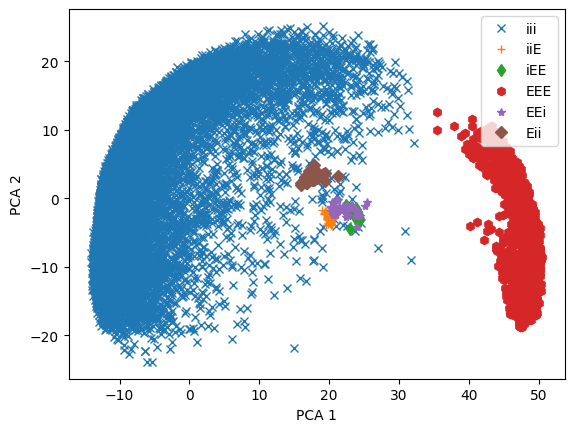

In [2]:
import matplotlib.pyplot as plt
from utils.seqlab import Index_Dictionary
import pandas as pd

# plot pca analysis
average_f1_score_1_token_analysis_pca_path = os.path.join("motif_analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv")
df = pd.read_csv(average_f1_score_1_token_analysis_pca_path)
unique_prediction_ids = df["prediction_id"].unique().tolist()
markers = ['x', '+', 'd', 'h', '*', 'D']

# plot pca.
for i, j in zip(unique_prediction_ids, markers):
    filtered_df = df[df["prediction_id"] == i]
    x = filtered_df["nf-0"]
    y = filtered_df["nf-1"]
    plt.plot(
        x, 
        y,
        j,
        label=Index_Dictionary[i]
    )

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(loc="upper right")

plt.show()


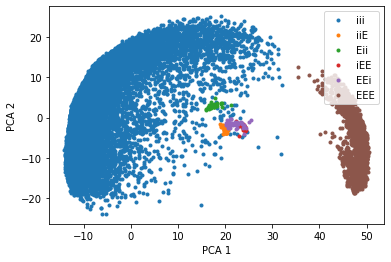

In [8]:
import matplotlib.pyplot as plt
from utils.seqlab import Index_Dictionary, all_label_ids
import pandas as pd

# plot pca analysis
average_f1_score_1_token_analysis_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv")
df = pd.read_csv(average_f1_score_1_token_analysis_pca_path)
unique_prediction_ids = df["prediction_id"].unique().tolist()
markers = ['x', '+', 'd', 'h', '*', 'D']

# plot pca.
for i, j in zip(all_label_ids, markers):
    filtered_df = df[df["prediction_id"] == i]
    x = filtered_df["nf-0"]
    y = filtered_df["nf-1"]
    plt.plot(
        x, 
        y,
        ".",
        label=Index_Dictionary[i]
    )

# plt.xlim(-50, 50)
# plt.ylim(-50, 50)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(loc="upper right")

plt.show()


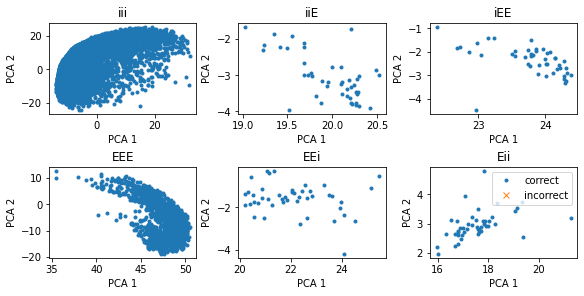

In [83]:
import pandas as pd
import os

nrows = 2
ncols = 3
idx = 0
df = pd.read_csv(os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv"))
figs, axes = plt.subplots(nrows, ncols, constrained_layout=True, figsize=(8, 4))
for r in range(nrows):
    for c in range(ncols):
        i = unique_prediction_ids[idx]
        j = markers[idx]
        filtered_df = df[df["prediction_id"] == i]
        correct_df = df[(df["prediction_id"] == i) & (df["target_id"] == i)]
        false_df = df[(df["prediction_id"] != i) & (df["target_id"] == i)]
        correct_x = correct_df["nf-0"]
        correct_y = correct_df["nf-1"]
        false_x = false_df["nf-0"]
        false_y = false_df["nf-1"]
        axes[r][c].plot(
            correct_x, 
            correct_y,
            '.',
            # color="green",
            label=f"correct"
        )
        axes[r][c].plot(
            false_x, 
            false_y,
            'x',
            # color="red",
            label=f"incorrect"
        )
        axes[r][c].set_xlabel("PCA 1")
        axes[r][c].set_ylabel("PCA 2")
        axes[r][c].set_title(f"{Index_Dictionary[i]}")
        idx += 1

plt.legend(loc="upper right")
plt.show()

In [4]:
# pca with sklearn.
# work in average F1 score 0.9 to 1.
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

average_f1_score_09_1_path = os.path.join("motif_analysis", "token_analysis", "average_f1_score_09_1_token_analysis.csv")
n_components = 2
avg_f1_score_09_1_df = pd.read_csv(average_f1_score_09_1_path)
print(avg_f1_score_09_1_df.shape)
avg_f1_score_09_1_feature_df = avg_f1_score_09_1_df[[f"feature-{i}" for i in range(768)]]
avg_f1_score_09_1_feature_std = (avg_f1_score_09_1_feature_df - avg_f1_score_09_1_feature_df.mean()) / avg_f1_score_09_1_feature_df.std()
avg_f1_score_09_1_feature_std.shape

(107520, 772)


(107520, 768)

In [5]:
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(avg_f1_score_09_1_feature_std)
principal_components_df = pd.DataFrame(data=principal_components, columns=[f"nf-{i}" for i in range(n_components)])
print(principal_components_df.shape)

(107520, 2)


In [7]:
# merge dataset with pca features.
avg_f1_score_09_1_df["nf-0"] = principal_components_df["nf-0"]
avg_f1_score_09_1_df["nf-1"] = principal_components_df["nf-1"]
average_f1_score_09_1_token_analysis_pca_path = os.path.join("motif_analysis", "token_analysis", "average_f1_score_09_1_token_analysis_pca.csv")
avg_f1_score_09_1_df.to_csv(
    average_f1_score_09_1_token_analysis_pca_path,
    index=False
)

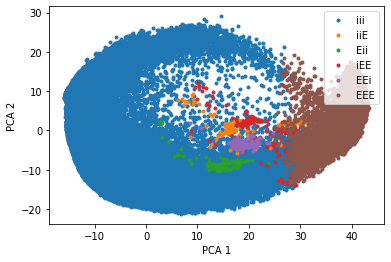

In [7]:
import matplotlib.pyplot as plt
from utils.seqlab import Index_Dictionary, all_label_ids
import pandas as pd


# plot pca analysis
average_f1_score_09_1_token_analysis_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_pca.csv")
df = pd.read_csv(average_f1_score_09_1_token_analysis_pca_path)
unique_prediction_ids = df["prediction_id"].unique().tolist()
markers = ['x', '+', 'd', 'h', '*', 'D']

# plot pca.
for i, j in zip(all_label_ids, markers):
    filtered_df = df[df["prediction_id"] == i]
    x = filtered_df["nf-0"]
    y = filtered_df["nf-1"]
    plt.plot(
        x, 
        y,
        ".",
        label=Index_Dictionary[i]
    )

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(loc="upper right")

plt.show()

Display PCA

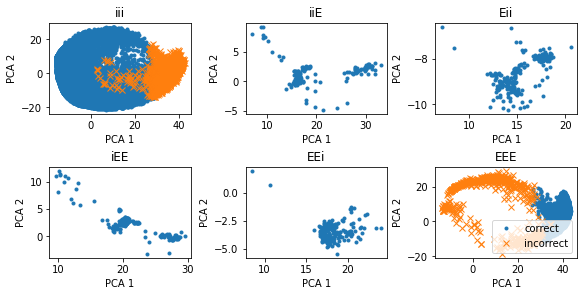

In [105]:
import pandas as pd
import os
from utils.seqlab import splice_site_ids

df = pd.read_csv(os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_pca.csv"))

In [ ]:
label_ids = [0] + splice_site_ids + [7]
nrows = 2
ncols = 3
idx = 0
figs, axes = plt.subplots(nrows, ncols, constrained_layout=True, figsize=(8, 4))
for r in range(nrows):
    for c in range(ncols):
        i = label_ids[idx]
        filtered_df = df[df["prediction_id"] == i]
        correct_df = df[(df["prediction_id"] == i) & (df["target_id"] == i)]
        false_df = df[(df["prediction_id"] != i) & (df["target_id"] == i)]
        correct_x = correct_df["nf-0"]
        correct_y = correct_df["nf-1"]
        false_x = false_df["nf-0"]
        false_y = false_df["nf-1"]
        axes[r][c].plot(
            correct_x, 
            correct_y,
            '.',
            label=f"correct"
        )
        axes[r][c].plot(
            false_x, 
            false_y,
            'x',
            label=f"incorrect"
        )
        axes[r][c].set_xlabel("PCA 1")
        axes[r][c].set_ylabel("PCA 2")
        axes[r][c].set_title(f"{Index_Dictionary[i]}")
        # axes[r][c].legend(loc="upper right")
        idx += 1

plt.legend(loc="lower right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\.virtualenv\sequence-processing\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


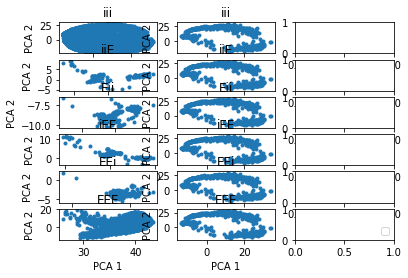

In [94]:
import pandas as pd
import os
from utils.seqlab import splice_site_ids

df = pd.read_csv(os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_pca.csv"))
label_ids = [0] + splice_site_ids + [7]
nrows = 6
ncols = 3
idx = 0

figs, axes = plt.subplots(nrows, ncols, constrained_layout=True)
for r in range(nrows):
    cur_label_id = label_ids[idx]
    correct_df = df[(df["prediction_id"] == cur_label_id) & (df["target_id"] == cur_label_id)]
    false_df = df[(df["prediction_id"] != i) & (df["target_id"] == i)]

    dfs = [correct_df, false_df, [correct_df, false_df]]
    for c in range(ncols):
        cur_df = dfs[c]
        if type(cur_df) != list:
            axes[r][c].plot(
                cur_df["nf-0"], 
                cur_df["nf-1"],
                '.',
            )
            axes[r][c].set_xlabel("PCA 1")
            axes[r][c].set_ylabel("PCA 2")
            axes[r][c].set_title(f"{Index_Dictionary[cur_label_id]}")
        
    idx += 1

plt.legend(loc="lower right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


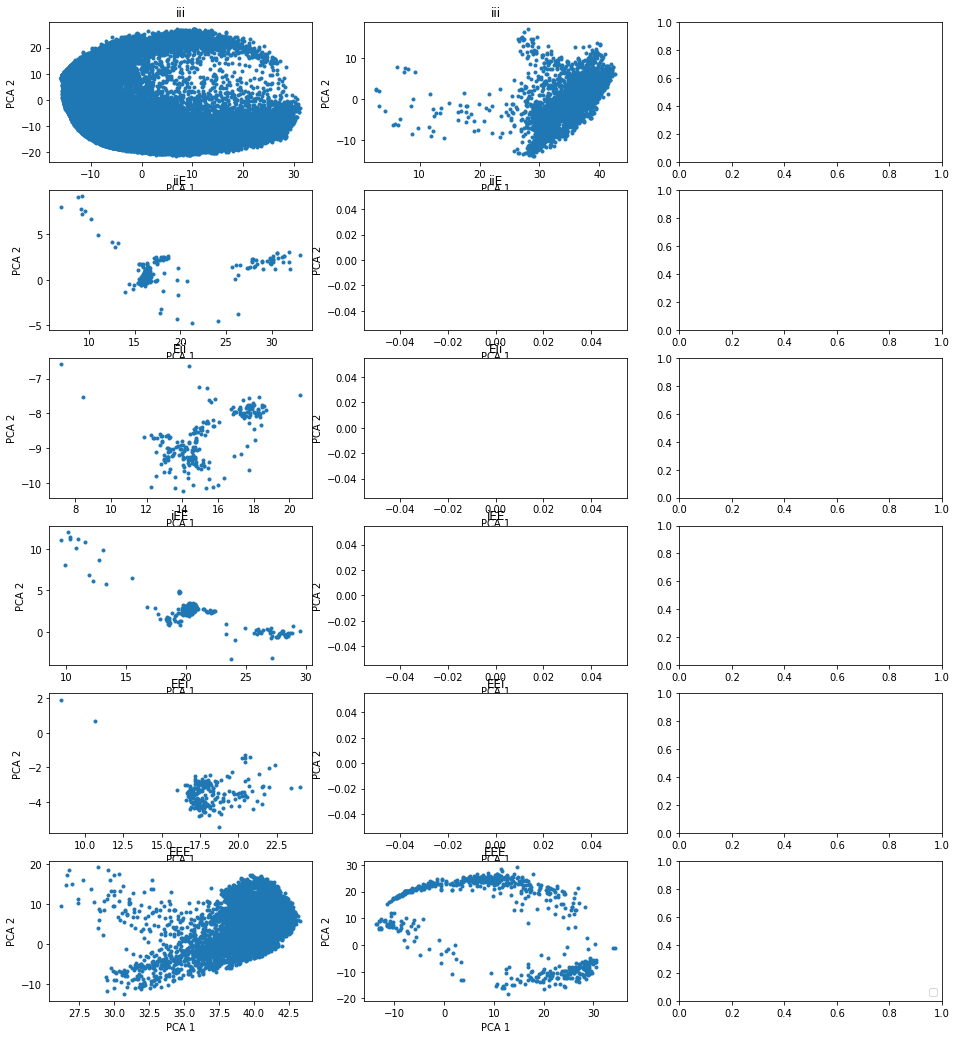

In [102]:
from utils.seqlab import all_label_ids

nrows = 6
ncols = 3
idx = 0
figs, axes = plt.subplots(nrows, ncols, figsize=(16, 18))
for r in range(nrows):
    cur_label_id = all_label_ids[idx]
    correct_df = df[(df["prediction_id"] == cur_label_id) & (df["target_id"] == cur_label_id)]
    false_df = df[(df["prediction_id"] != cur_label_id) & (df["target_id"] == cur_label_id)]

    dfs = [correct_df, false_df, [correct_df, false_df]]
    for c in range(ncols):
        cur_df = dfs[c]
        if type(cur_df) != list:
            axes[r][c].plot(
                cur_df["nf-0"], 
                cur_df["nf-1"],
                '.',
            )
            axes[r][c].set_xlabel("PCA 1")
            axes[r][c].set_ylabel("PCA 2")
            axes[r][c].set_title(f"{Index_Dictionary[cur_label_id]}")
        
    idx += 1

plt.legend(loc="lower right")
plt.show()

In [10]:
def plot_pca(df1, df2, markers=('.', 'x'), labels=("ft", "fb")):
    from utils.seqlab import all_label_ids, Index_Dictionary
    import matplotlib.pyplot as plt
    nrows = 2
    ncols = 3
    idx = 0
    figs, axes = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True, figsize=(8, 4))
    for i in range(nrows):
        for j in range(ncols):
            label_id = all_label_ids[idx]
            correct_df1 = df1[(df1["target_id"] == label_id) & (df1["prediction_id"] == label_id)]
            axes[i][j].plot(
                correct_df1["nf-0"],
                correct_df1["nf-1"],
                '.',
                label=labels[0],
            )
            correct_df2 = df2[(df2["target_id"] == label_id) & (df2["prediction_id"] == label_id)]
            axes[i][j].plot(
                correct_df2["nf-0"],
                correct_df2["nf-1"],
                '.',
                label=labels[1],
            )
            axes[i][j].set_title(Index_Dictionary[label_id])
            idx += 1

    plt.legend(loc="lower right")
    plt.show()


### Display PCA Avg F1 = 1 and Avg F1 = 0.9

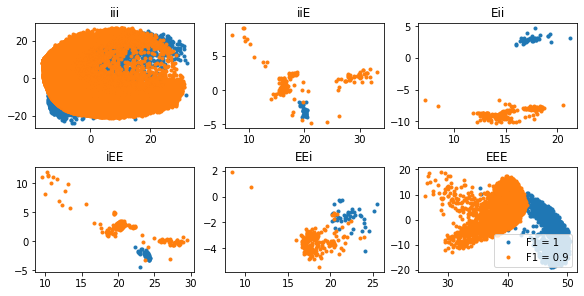

In [11]:
# Comparison between Avg F1 = 1 and 0.9-1.
# compare two correct prediction.
import os
import pandas as pd
from utils.seqlab import splice_site_ids

average_f1_score_1_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv")
average_f1_score_09_1_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_pca.csv")
df1 = pd.read_csv(average_f1_score_1_pca_path)
df2 = pd.read_csv(average_f1_score_09_1_pca_path)

plot_pca(
    df1,
    df2,
    labels=("F1 = 1", "F1 = 0.9")
)

In [3]:
# observe PCA between labels in avg 1 and 0.9
import os
import pandas as pd
import matplotlib.pyplot as plt
from utils.seqlab import all_label_ids, Index_Dictionary

average_f1_score_1_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv")
average_f1_score_09_1_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_pca.csv")
df1 = pd.read_csv(average_f1_score_1_pca_path)
df2 = pd.read_csv(average_f1_score_09_1_pca_path)
        

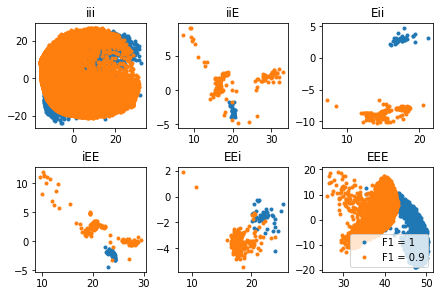

In [12]:
nrows = 2
ncols = 3
index = 0
figs, axes = plt.subplots(nrows, ncols, constrained_layout=True)
for row in range(nrows):
    for col in range(ncols):
        cur_label_id = all_label_ids[index]
        x1 = df1[(df1["target_id"] == cur_label_id) & (df1["prediction_id"] == cur_label_id)]["nf-0"]
        y1 = df1[(df1["target_id"] == cur_label_id) & (df1["prediction_id"] == cur_label_id)]["nf-1"]
        axes[row][col].plot(
            x1, y1, ".", label="F1 = 1"
        )
        x2 = df2[(df2["target_id"] == cur_label_id) & (df2["prediction_id"] == cur_label_id)]["nf-0"]
        y2 = df2[(df2["target_id"] == cur_label_id) & (df2["prediction_id"] == cur_label_id)]["nf-1"]
        axes[row][col].plot(
            x2, y2, ".", label="F1 = 0.9"
        )
        axes[row][col].set_title(Index_Dictionary[cur_label_id])
        index += 1

plt.legend(loc="lower right")

In [13]:
df1.head(1)

,token_id,prediction_id,target_id,bert_value,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,...,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767,nf-0,nf-1
0,2,0,-100,0.5987292528152466 1.535011649131775 -1.131779...,0.598729,1.535012,-1.13178,0.769095,1.701034,-0.424053,...,0.813483,-1.487176,-0.335771,-0.408056,0.352955,-1.638533,0.78263,-0.097832,-12.262529,-16.561009


In [16]:
df1_val_counts = df1["token_id"].value_counts()
df2_val_counts = df2["token_id"].value_counts()

In [56]:
# top 5
df1_top5_token_ids = df1_val_counts.index[0:5]
df2_top5_token_ids = df2_val_counts.index[0:5]

set1 = set(df1_top5_token_ids)
set2 = set(df2_top5_token_ids)
print(set1, set2)
complete_set = set1.union(set2)
print(complete_set)

{65, 68, 40, 20, 56} {65, 33, 40, 20, 56}
{65, 33, 68, 40, 20, 56}


IndexError: list index out of range

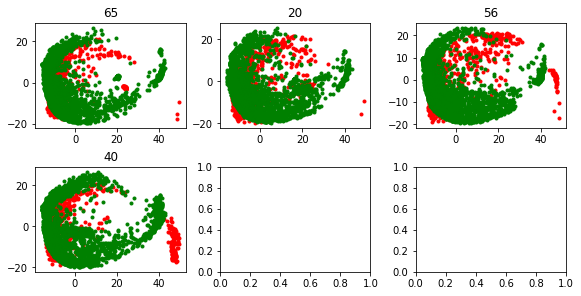

In [109]:
# observe if there is polysemy token.

import matplotlib.pyplot as plt

nrows = 2
ncols = 3
token_ids = list(complete_set)
index = 0
figs, axes = plt.subplots(nrows, ncols, constrained_layout=True, figsize=(8, 4))
for i in range(nrows):
    for j in range(ncols):
        cur_token_id = token_ids[index]
        token_df1 = df1[(df1["token_id"] == cur_token_id)]
        token_df1 = token_df1[token_df1["prediction_id"] == token_df1["target_id"]]
        axes[i][j].plot(
            token_df1["nf-0"],
            token_df1["nf-1"], 
            '.',
            color="red",
            label="F1 = 1"
        )
        token_df2 = df2[(df2["token_id"] == cur_token_id)]
        token_df2 = token_df2[token_df2["prediction_id"] == token_df2["target_id"]]
        axes[i][j].plot(
            token_df2["nf-0"],
            token_df2["nf-1"], 
            '.',
            color="green",
            label="F1 = [0.9, 1)"
        )
        axes[i][j].set_title(f"{cur_token_id}")
        index += 1


### Polysemy Tokens

In [4]:
# intialize BertTokenizer.
from transformers import BertTokenizer
import os

pretrained_path = os.path.join("pretrained", "3-new-12w-0")
tokenizer = BertTokenizer.from_pretrained(pretrained_path)
tokenizer.ids_to_tokens[10]

'ATT'

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from utils.seqlab import all_label_ids, Index_Dictionary

average_f1_score_1_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv")
average_f1_score_09_1_pca_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_pca.csv")
df1 = pd.read_csv(average_f1_score_1_pca_path)
df2 = pd.read_csv(average_f1_score_09_1_pca_path)
df1_val_counts = df1["token_id"].value_counts()
df2_val_counts = df2["token_id"].value_counts()

# top 5
df1_top5_token_ids = df1_val_counts.index[0:5]
df2_top5_token_ids = df2_val_counts.index[0:5]

set1 = set(df1_top5_token_ids)
set2 = set(df2_top5_token_ids)
print(set1, set2)
complete_set = set1.union(set2)
print(complete_set)

{65, 68, 40, 20, 56} {65, 33, 40, 20, 56}
{65, 33, 68, 40, 20, 56}


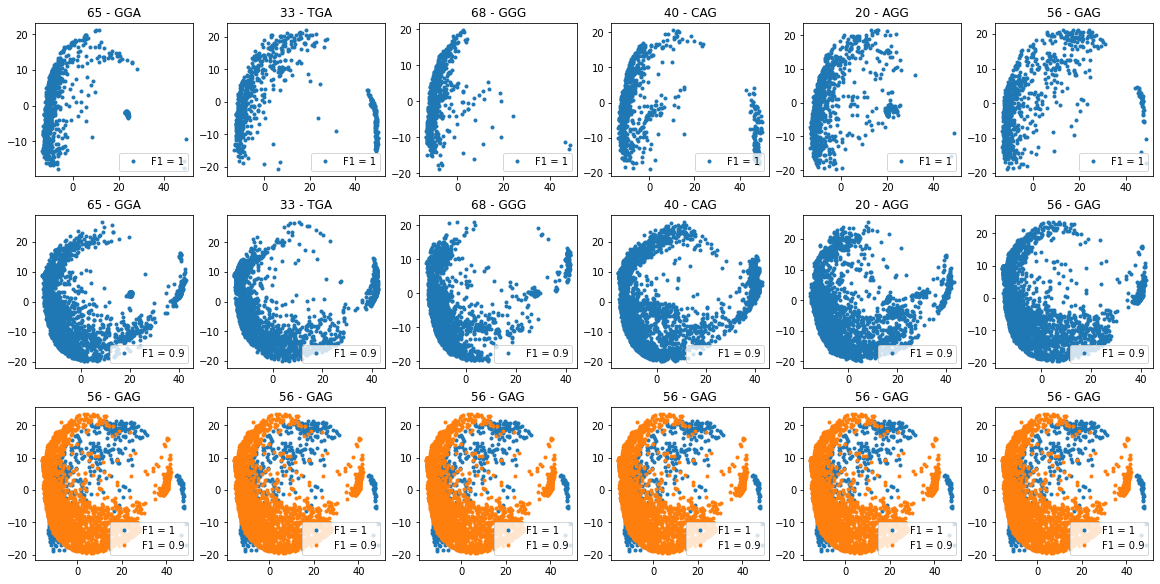

In [20]:
# observe if there is polysemy token.

import matplotlib.pyplot as plt

nrows = 3
ncols = 6
token_ids = list(complete_set)
figs, axes = plt.subplots(nrows, ncols, constrained_layout=True, figsize=(16, 8))
dfs = [df1, df2, [df1, df2]]
series_labels = ["F1 = 1", "F1 = 0.9", ["F1 = 1", "F1 = 0.9"]]
for i in range(nrows):
    cur_df = dfs[i]
    series_label = series_labels[i]
    index = 0
    if type(cur_df) != list:
        for j in range(ncols):
            cur_token_id = token_ids[index]
            cur_token_df = cur_df[(cur_df["token_id"] == cur_token_id)]
            cur_token_df = cur_token_df[cur_token_df["prediction_id"] == cur_token_df["target_id"]]
            axes[i][j].plot(
                cur_token_df["nf-0"],
                cur_token_df["nf-1"], 
                '.',
                label=f"{series_label}"
            )
            index += 1
            axes[i][j].set_title(f"{cur_token_id} - {tokenizer.ids_to_tokens[cur_token_id]}")
            axes[i][j].legend(loc="lower right")
    else:
        _df1 = cur_df[0]
        _df2 = cur_df[1]
        for j in range(ncols):
            token_df1 = _df1[(_df1["token_id"] == cur_token_id)]
            token_df1 = token_df1[token_df1["prediction_id"] == token_df1["target_id"]]
            axes[i][j].plot(
                token_df1["nf-0"],
                token_df1["nf-1"], 
                '.',
                label="F1 = 1"
            )
            token_df2 = _df2[(_df2["token_id"] == cur_token_id)]
            token_df2 = token_df2[token_df2["prediction_id"] == token_df2["target_id"]]
            axes[i][j].plot(
                token_df2["nf-0"],
                token_df2["nf-1"], 
                '.',
                label="F1 = 0.9"
            )
            axes[i][j].set_title(f"{cur_token_id} - {tokenizer.ids_to_tokens[cur_token_id]}")
            axes[i][j].legend(loc="lower right")
            index += 1


{56, 40, 20} {40, 65, 20}
{65, 20, 56, 40}


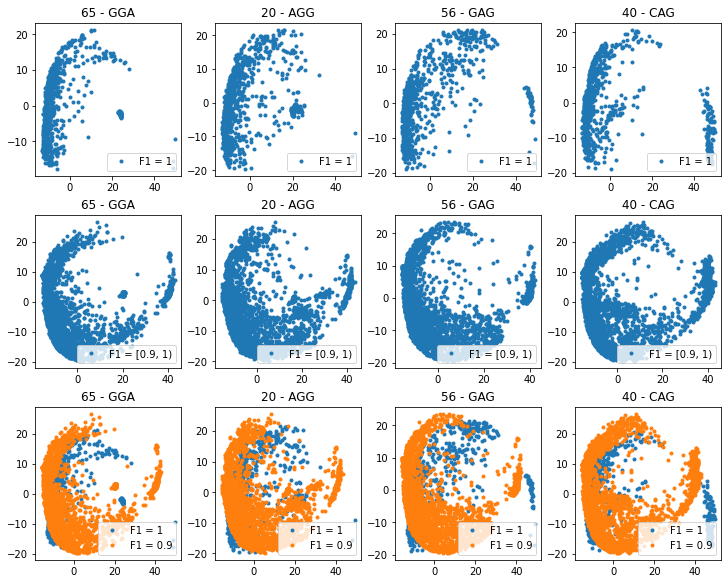

In [31]:
# observe if there is polysemy token.
# top 3
df1_top5_token_ids = df1_val_counts.index[0:3]
df2_top5_token_ids = df2_val_counts.index[0:3]

set1 = set(df1_top5_token_ids)
set2 = set(df2_top5_token_ids)
print(set1, set2)
complete_set = set1.union(set2)
print(complete_set)

import matplotlib.pyplot as plt

nrows = 3
ncols = 4
token_ids = list(complete_set)
figs, axes = plt.subplots(nrows, ncols, constrained_layout=True, figsize=(10, 8))
dfs = [df1, df2, [df1, df2]]
series_labels = ["F1 = 1", "F1 = [0.9, 1)", ["F1 = 1", "F1 = 0.9"]]
for i in range(nrows):
    cur_df = dfs[i]
    series_label = series_labels[i]
    index = 0
    if type(cur_df) != list:
        for j in range(ncols):
            cur_token_id = token_ids[index]
            cur_token_df = cur_df[(cur_df["token_id"] == cur_token_id)]
            cur_token_df = cur_token_df[cur_token_df["prediction_id"] == cur_token_df["target_id"]]
            axes[i][j].plot(
                cur_token_df["nf-0"],
                cur_token_df["nf-1"], 
                '.',
                label=f"{series_label}"
            )
            index += 1
            axes[i][j].set_title(f"{cur_token_id} - {tokenizer.ids_to_tokens[cur_token_id]}")
            axes[i][j].legend(loc="lower right")
    else:
        _df1 = cur_df[0]
        _df2 = cur_df[1]
        for j in range(ncols):
            cur_token_id = token_ids[index]
            token_df1 = _df1[(_df1["token_id"] == cur_token_id)]
            token_df1 = token_df1[token_df1["prediction_id"] == token_df1["target_id"]]
            axes[i][j].plot(
                token_df1["nf-0"],
                token_df1["nf-1"], 
                '.',
                label="F1 = 1"
            )
            token_df2 = _df2[(_df2["token_id"] == cur_token_id)]
            token_df2 = token_df2[token_df2["prediction_id"] == token_df2["target_id"]]
            axes[i][j].plot(
                token_df2["nf-0"],
                token_df2["nf-1"], 
                '.',
                label="F1 = 0.9"
            )
            axes[i][j].set_title(f"{cur_token_id} - {tokenizer.ids_to_tokens[cur_token_id]}")
            axes[i][j].legend(loc="lower right")
            index += 1

{56, 40, 20} {40, 65, 20}
{65, 20, 56, 40}


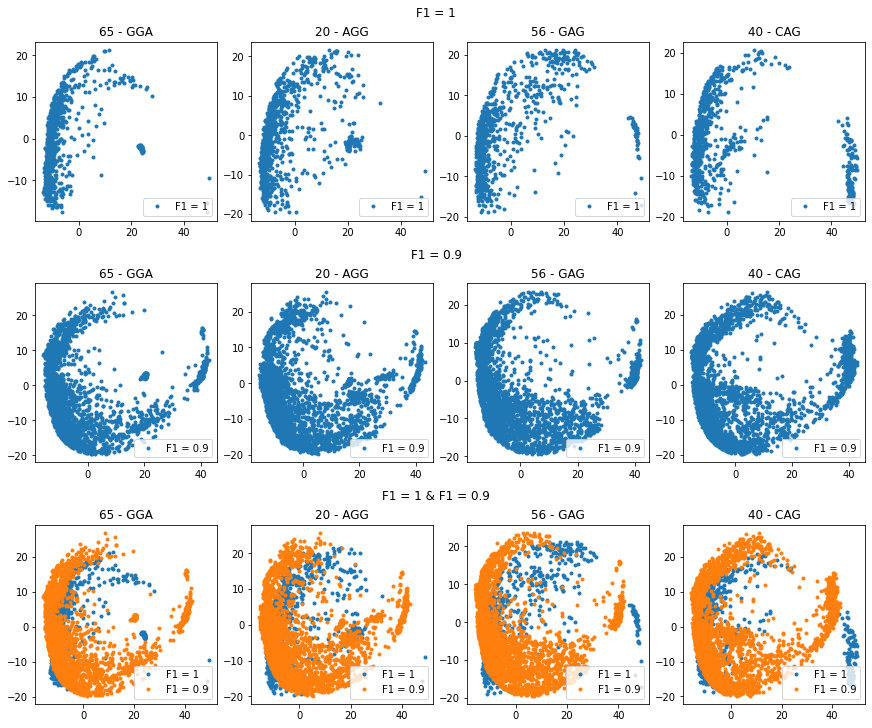

In [38]:
# observe if there is polysemy token.
# top 3
df1_top5_token_ids = df1_val_counts.index[0:3]
df2_top5_token_ids = df2_val_counts.index[0:3]

set1 = set(df1_top5_token_ids)
set2 = set(df2_top5_token_ids)
print(set1, set2)
complete_set = set1.union(set2)
print(complete_set)

import matplotlib.pyplot as plt

nrows = 3
ncols = 4
token_ids = list(complete_set)
n_token = len(token_ids)
dfs = [df1, df2, [df1, df2]]
series_labels = ["F1 = 1", "F1 = 0.9", ["F1 = 1", "F1 = 0.9"]]
main_fig = plt.figure(constrained_layout=True, figsize=(12, 10))
(fig1, fig2, fig3) = main_fig.subfigures(3, 1)
arr_figs = [fig1, fig2, fig3]
arr_title = ["F1 = 1", "F1 = 0.9", "F1 = 1 & F1 = 0.9"]
for fig, cur_df, title, series_label in zip(arr_figs, dfs, arr_title, series_labels):
    _axes = fig.subplots(1, n_token)
    fig.suptitle(title)
    if type(cur_df) != list:
        for i in range(n_token):
            cur_token_id = token_ids[i]
            cur_token_df = cur_df[(cur_df["token_id"] == cur_token_id)]
            cur_token_df = cur_token_df[cur_token_df["prediction_id"] == cur_token_df["target_id"]]
            _axes[i].plot(
                cur_token_df["nf-0"],
                cur_token_df["nf-1"], 
                '.',
                label=f"{series_label}"
            )
            _axes[i].set_title(f"{cur_token_id} - {tokenizer.ids_to_tokens[cur_token_id]}")
            _axes[i].legend(loc="lower right")
    else:
        _df1 = cur_df[0]
        _df2 = cur_df[1]
        for i in range(n_token):
            cur_token_id = token_ids[i]
            token_df1 = _df1[(_df1["token_id"] == cur_token_id)]
            token_df1 = token_df1[token_df1["prediction_id"] == token_df1["target_id"]]
            _axes[i].plot(
                token_df1["nf-0"],
                token_df1["nf-1"], 
                '.',
                label="F1 = 1"
            )
            token_df2 = _df2[(_df2["token_id"] == cur_token_id)]
            token_df2 = token_df2[token_df2["prediction_id"] == token_df2["target_id"]]
            _axes[i].plot(
                token_df2["nf-0"],
                token_df2["nf-1"], 
                '.',
                label="F1 = 0.9"
            )
            _axes[i].set_title(f"{cur_token_id} - {tokenizer.ids_to_tokens[cur_token_id]}")
            _axes[i].legend(loc="lower right")


In [28]:
# Analysis on splice site motif.
# donor
donor_tokens = ["GTA", "GTG"]
donor_token_ids = [tokenizer.convert_tokens_to_ids(t) for t in donor_tokens]
donor_token_ids

[57, 60]

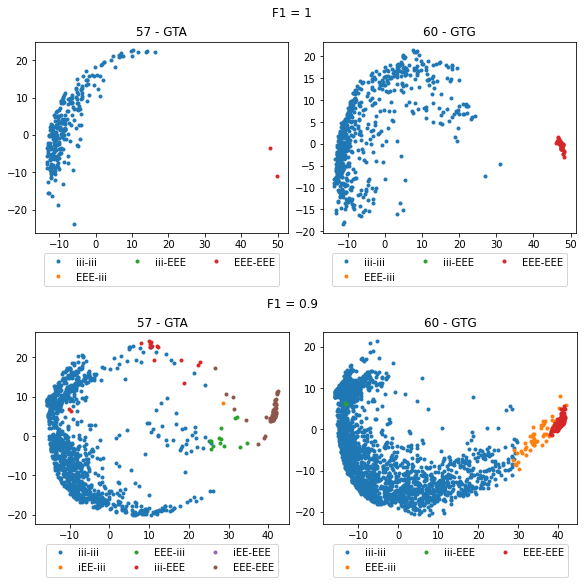

In [62]:
import matplotlib.pyplot as plt

nrows = 3
ncols = 4
token_ids = donor_token_ids
n_token = len(token_ids)
dfs = [df1, df2]
series_labels = ["F1 = 1", "F1 = 0.9"]
main_fig = plt.figure(constrained_layout=True, figsize=(8, 8))
(fig1, fig2) = main_fig.subfigures(2, 1)
arr_figs = [fig1, fig2]
arr_title = ["F1 = 1", "F1 = 0.9"]
for fig, cur_df, title, series_label in zip(arr_figs, dfs, arr_title, series_labels):
    _axes = fig.subplots(1, n_token)
    fig.suptitle(title)
    if type(cur_df) != list:
        for i in range(n_token):
            cur_token_id = token_ids[i]
            cur_token_df = cur_df[(cur_df["token_id"] == cur_token_id)]
            unique_prediction_ids = cur_token_df["prediction_id"].sort_values(ascending=True).unique()
            unique_target_ids = cur_token_df["target_id"].sort_values(ascending=True).unique()
            for t_id in unique_target_ids:
                for p_id in unique_prediction_ids:
                    _cur_token_df = cur_token_df[(cur_token_df["target_id"] == t_id) & (cur_token_df["prediction_id"] == p_id)]
                    # if _cur_token_df.shape[0] > 0:
                    _axes[i].plot(
                        _cur_token_df["nf-0"],
                        _cur_token_df["nf-1"], 
                        '.',
                        label=f"{Index_Dictionary[p_id]}-{Index_Dictionary[t_id]}"
                    )
            _axes[i].set_title(f"{cur_token_id} - {tokenizer.ids_to_tokens[cur_token_id]}")
            # false
            # false_df = cur_df[(cur_df["token_id"] == cur_token_id)]
            # false_df = false_df[(false_df["target_id"] == 0) & (false_df["prediction_id"] != 0)]
            # _axes[i].plot(
            #     false_df["nf-0"],
            #     false_df["nf-1"], 
            #     '.',
            #     label=f"incorrect"
            # )
            _axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=True, ncol=3)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
plt.show()

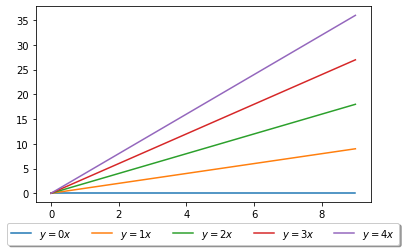

In [42]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(10)

fig = plt.figure()
ax = plt.subplot(111)

for i in range(5):
    line, = ax.plot(x, i * x, label='$y = %ix$'%i)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=True, shadow=True, ncol=5)

plt.show()

In [5]:
# acceptor
acceptor_tokens = ["CAG", "TAG", "AAG"]
acceptor_token_ids = [tokenizer.convert_tokens_to_ids(t) for t in acceptor_tokens]
acceptor_token_ids

[40, 24, 8]

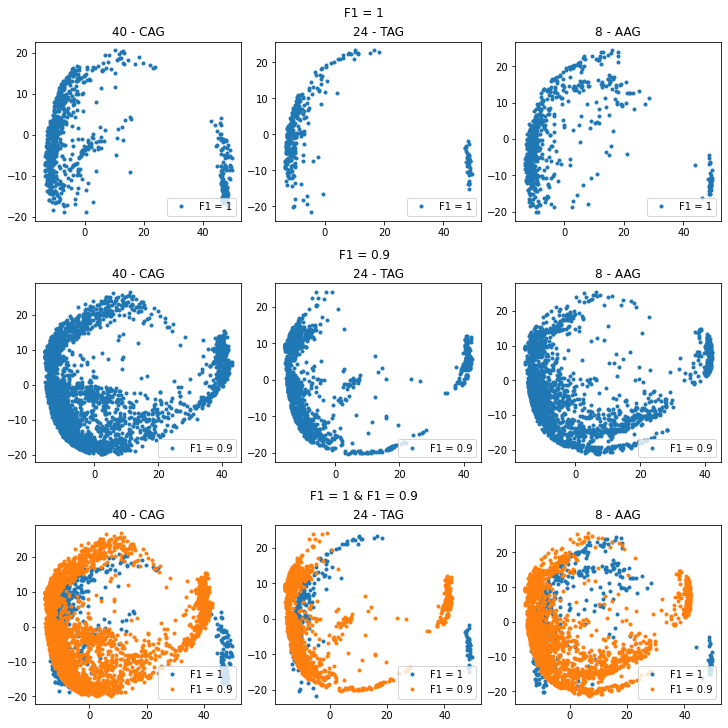

In [13]:
import matplotlib.pyplot as plt

nrows = 3
ncols = 4
token_ids = acceptor_token_ids
n_token = len(token_ids)
dfs = [df1, df2, [df1, df2]]
series_labels = ["F1 = 1", "F1 = 0.9", ["F1 = 1", "F1 = 0.9"]]
main_fig = plt.figure(constrained_layout=True, figsize=(10, 10))
(fig1, fig2, fig3) = main_fig.subfigures(3, 1)
arr_figs = [fig1, fig2, fig3]
arr_title = ["F1 = 1", "F1 = 0.9", "F1 = 1 & F1 = 0.9"]
for fig, cur_df, title, series_label in zip(arr_figs, dfs, arr_title, series_labels):
    _axes = fig.subplots(1, n_token)
    fig.suptitle(title)
    if type(cur_df) != list:
        for i in range(n_token):
            cur_token_id = token_ids[i]
            cur_token_df = cur_df[(cur_df["token_id"] == cur_token_id)]
            cur_token_df = cur_token_df[cur_token_df["prediction_id"] == cur_token_df["target_id"]]
            _axes[i].plot(
                cur_token_df["nf-0"],
                cur_token_df["nf-1"], 
                '.',
                label=f"{series_label}"
            )
            _axes[i].set_title(f"{cur_token_id} - {tokenizer.ids_to_tokens[cur_token_id]}")
            _axes[i].legend(loc="lower right")
    else:
        _df1 = cur_df[0]
        _df2 = cur_df[1]
        for i in range(n_token):
            cur_token_id = token_ids[i]
            token_df1 = _df1[(_df1["token_id"] == cur_token_id)]
            token_df1 = token_df1[token_df1["prediction_id"] == token_df1["target_id"]]
            _axes[i].plot(
                token_df1["nf-0"],
                token_df1["nf-1"], 
                '.',
                label="F1 = 1"
            )
            token_df2 = _df2[(_df2["token_id"] == cur_token_id)]
            token_df2 = token_df2[token_df2["prediction_id"] == token_df2["target_id"]]
            _axes[i].plot(
                token_df2["nf-0"],
                token_df2["nf-1"], 
                '.',
                label="F1 = 0.9"
            )
            _axes[i].set_title(f"{cur_token_id} - {tokenizer.ids_to_tokens[cur_token_id]}")
            _axes[i].legend(loc="lower right")

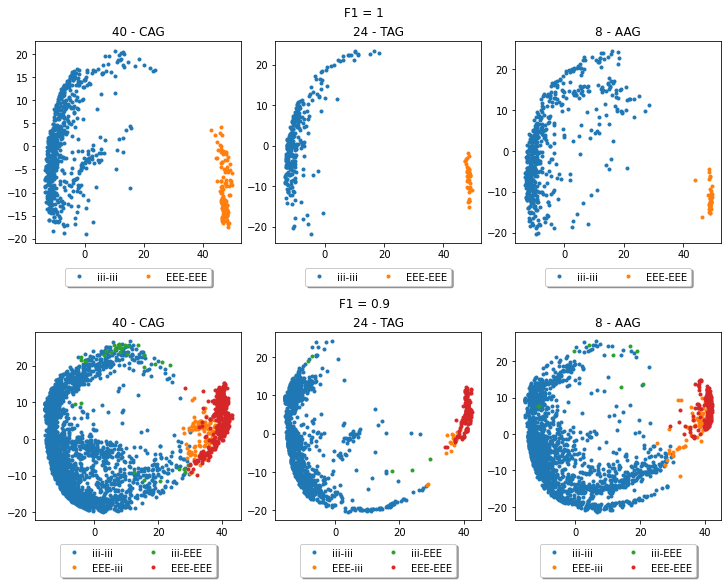

In [67]:
import matplotlib.pyplot as plt

nrows = 3
ncols = 4
token_ids = acceptor_token_ids
n_token = len(token_ids)
dfs = [df1, df2]
series_labels = ["F1 = 1", "F1 = 0.9"]
main_fig = plt.figure(constrained_layout=True, figsize=(10, 8))
(fig1, fig2) = main_fig.subfigures(2, 1)
arr_figs = [fig1, fig2]
arr_title = ["F1 = 1", "F1 = 0.9"]
for fig, cur_df, title, series_label in zip(arr_figs, dfs, arr_title, series_labels):
    _axes = fig.subplots(1, n_token)
    fig.suptitle(title)
    if type(cur_df) != list:
        for i in range(n_token):
            cur_token_id = token_ids[i]
            cur_token_df = cur_df[(cur_df["token_id"] == cur_token_id)]
            unique_target_ids = cur_token_df["target_id"].sort_values(ascending=True).unique()
            unique_prediction_ids =  cur_token_df["prediction_id"].sort_values(ascending=True).unique()
            for t_id in unique_target_ids:
                for p_id in unique_prediction_ids:
                    _cur_token_df = cur_token_df[(cur_token_df["target_id"] == t_id) & (cur_token_df["prediction_id"] == p_id)]
                    if _cur_token_df.shape[0] > 0:
                        _axes[i].plot(
                            _cur_token_df["nf-0"],
                            _cur_token_df["nf-1"], 
                            '.',
                            label=f"{Index_Dictionary[p_id]}-{Index_Dictionary[t_id]}"
                        )
            _axes[i].set_title(f"{cur_token_id} - {tokenizer.ids_to_tokens[cur_token_id]}")
            # false
            # false_df = cur_df[(cur_df["token_id"] == cur_token_id)]
            # false_df = false_df[(false_df["target_id"] == 7) & (false_df["prediction_id"] != 7)]
            # _axes[i].plot(
            #     false_df["nf-0"],
            #     false_df["nf-1"], 
            #     '.',
            #     label=f"incorrect"
            # )
            # _axes[i].legend(loc="lower right")
            _axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)


array([<AxesSubplot:title={'center':'feature-1'}, xlabel='prediction_id'>,
       <AxesSubplot:title={'center':'feature-2'}, xlabel='prediction_id'>],
      dtype=object)

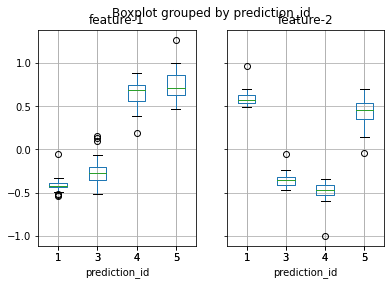

In [9]:
# boxplot.

X = ss_token_reps_df[[f"feature-{i}" for i in range(768)]].to_numpy()
labels = ss_token_reps_df["prediction_id"].to_numpy()
ss_token_reps_df.boxplot(by="prediction_id", column=["feature-1", "feature-2"])


eigen values and vector dimension (768,) (768, 768)
idx (768,), sorted eigen vector (768, 768)


c:\.virtualenv\sequence-processing\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


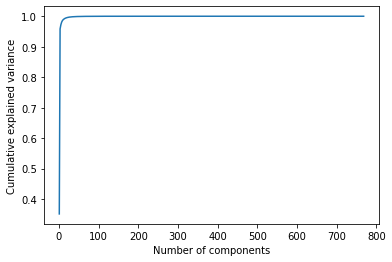

In [30]:
# compute covariance matrix.
X = StandardScaler().fit_transform(X)
cov = (X.T @ X) / (X.shape[0] - 1)

# performing eigen-decomposition.
eig_values, eig_vectors = np.linalg.eig(cov)
print("eigen values and vector dimension", eig_values.shape, eig_vectors.shape)

# determine which principal components to select.
idx = np.argsort(eig_values, axis=0)[::-1]
sorted_eig_vectors = eig_vectors[:, idx]
print(f"idx {idx.shape}, sorted eigen vector {sorted_eig_vectors.shape}")

cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
xint = range(1, len(cumsum) + 1)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
# plt.xticks(xint)
# plt.xlim(1, 768, 1)
plt.plot(xint, cumsum)
plt.show()


In [1]:
# PCA
import os
import pandas as pd
from utils.pca import PCA_Util

path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv")
dataframe = pd.read_csv(path)

pca = PCA_Util(dataframe, [f"feature-{i}" for i in range(768)])


<bound method NDFrame.head of        token_id  prediction_id  target_id  \
0             2              0       -100   
1            14              0          0   
2            42              0          0   
3            26              0          0   
4            26              0          0   
...         ...            ...        ...   
23035        10              0          0   
23036        25              0          0   
23037        21              0          0   
23038         6              0          0   
23039         3              0       -100   

                                              bert_value  feature-0  \
0      0.5987289547920227 1.5350109338760376 -1.13177...   0.598729   
1      0.645226776599884 1.1057463884353638 -0.988500...   0.645227   
2      0.6590502858161926 1.3099822998046875 -1.48484...   0.659050   
3      0.5989874601364136 1.3798731565475464 -1.27833...   0.598987   
4      0.6436380743980408 1.453780174255371 -1.338218...   0.643638   
...

In [2]:
pca.dataframe.head(5)

,token_id,prediction_id,target_id,bert_value,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,...,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767,nf-0,nf-1
0,2,0,-100,0.5987289547920227 1.5350109338760376 -1.13177...,0.598729,1.535011,-1.131780,0.769095,1.701033,-0.424053,...,0.813483,-1.487175,-0.335770,-0.408056,0.352956,-1.638532,0.782630,-0.097833,-12.262528,-16.561008
1,14,0,0,0.645226776599884 1.1057463884353638 -0.988500...,0.645227,1.105746,-0.988500,1.048968,1.746609,-0.747095,...,0.764826,-1.077138,-0.266482,-0.474709,0.373477,-1.665863,0.762050,-0.301003,-10.811294,-11.292125
2,42,0,0,0.6590502858161926 1.3099822998046875 -1.48484...,0.659050,1.309982,-1.484845,0.960860,1.864745,-0.668480,...,0.895121,-1.292902,-0.188040,-0.621346,0.277545,-1.659615,0.878678,-0.224651,-11.445734,-11.369141
3,26,0,0,0.5989874601364136 1.3798731565475464 -1.27833...,0.598987,1.379873,-1.278331,1.004261,1.844381,-0.661428,...,1.007873,-1.188743,-0.202197,-0.699785,0.307036,-1.635817,0.751317,-0.356715,-11.862713,-11.122044
4,26,0,0,0.6436380743980408 1.453780174255371 -1.338218...,0.643638,1.453780,-1.338219,0.994284,1.844847,-0.643750,...,1.012343,-1.242443,-0.184286,-0.699384,0.279862,-1.641129,0.768689,-0.376701,-11.778899,-11.458162


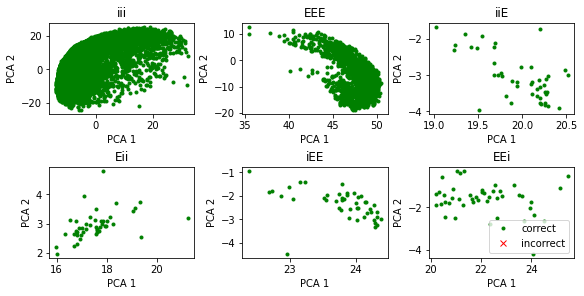

In [3]:
pca.plot(pca.dataframe)

In [ ]:
# compute the transformation.
eig_scores = np.dot(X, sorted_eig_vectors[:, :2])
colors = ["blue", "red", "green", "yellow", "gray", "black"]

print(eig_scores.shape)
def biplot(score, coeff, labels):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]

    for i, u in zip(splice_site_ids, [Index_Dictionary[a] for a in splice_site_ids]):
        print(i, u)
        xi = [
            score[j, 0] for j in range(score.shape[0]) if ss_token_reps_df["target_id"].tolist()[j] == u
        ]
        yi = [
            score[j, 1] for j in range(score.shape[0]) if ss_token_reps_df["target_id"].tolist()[j] == u
        ]
        plt.scatter(xi, yi, c=colors[i], label=u)
    for i in range(n):
        plt.arrow(
            0, 0, coeff[i, 0], coeff[i, 1], color="r", head_width=0.05, head_length=0.1
        )
        plt.text(
            coeff[i, 0] * 1.35,
            coeff[i, 1] * 1.35,
            labels[i],
            color="g",
            ha="center",
            va="center",
        )


plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

biplot(eig_scores, sorted_eig_vectors, [f"feature-{i}" for i in range(768)])
plt.legend()

In [20]:
ndf[ndf["comparison"] == 0]

,token,target,prediction,bert_value,comparison
1,GAA,iEE,iiE,0.3126485049724579 -1.088175892829895 -0.56700...,0
2,AGG,EEi,Eii,-0.1707116961479187 0.4697659909725189 1.07950...,0
3,GGT,Eii,iiE,-0.8013615608215332 0.10018081218004227 1.5437...,0
4,AGG,iiE,Eii,-0.11103878915309906 -0.24303054809570312 1.02...,0
5,GGA,iEE,iiE,-0.06882086396217346 0.0999293401837349 1.1488...,0
...,...,...,...,...,...
175,GGT,Eii,iiE,-0.12136223912239075 0.24540439248085022 1.074...,0
176,AGG,iiE,Eii,0.19183388352394104 -0.3378389775753021 0.5174...,0
177,GGA,iEE,EEE,0.17814867198467255 -0.09485137462615967 1.077...,0
178,AGG,EEi,EEE,0.021793914958834648 0.720974862575531 0.61671...,0


In [19]:
ndf.to_csv(
    os.path.join("motif_analysis", "token_analysis", "df-F1=1.csv"), 
    index=False
)

In [21]:
# something weird.
import os
import pandas as pd

path = os.path.join("prediction", "dataframe-F1 Score=1.csv")
tokens, predictions, targets = [], [], []
df = pd.read_csv(path)
for step, r in df.iterrows():
    input_tokens = r["input_tokens"].split(" ")
    prediction_tokens = r["prediction_tokens"].split(" ")
    target_tokens = r["target_tokens"].split(" ")

    for i, j, k in zip(input_tokens, prediction_tokens, target_tokens):
        tokens.append(i)
        predictions.append(j)
        targets.append(k)

df = pd.DataFrame(data={
    "token": tokens,
    "prediction": predictions,
    "target": targets
})
df.head(5)

,token,prediction,target
0,ACT,iii,iii
1,CTT,iii,iii
2,TTT,iii,iii
3,TTT,iii,iii
4,TTC,iii,iii


In [23]:
print(df.shape)
print(df[df["prediction"] == df["target"]].shape)
print(df[df["prediction"] != df["target"]].shape)

(22950, 3)
(22950, 3)
(0, 3)
